In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D
import os
import pathlib
import zipfile
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential

In [ ]:
!nvidia-smi

Fri Feb 24 04:14:00 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    29W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Get data (10% of 10 food classes from Food101) - https://www.kaggle.com/dansbecker/food-101 
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2023-02-24 04:14:00--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.212.128, 172.217.214.128, 172.253.114.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.212.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  96.0MB/s    in 1.7s    

2023-02-24 04:14:02 (96.0 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
for dirpath, dirnames, filenames in os.walk('10_food_classes_10_percent'):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}.")

There are 2 directories and 0 images in 10_food_classes_10_percent.
There are 10 directories and 0 images in 10_food_classes_10_percent/test.
There are 0 directories and 250 images in 10_food_classes_10_percent/test/chicken_curry.
There are 0 directories and 250 images in 10_food_classes_10_percent/test/sushi.
There are 0 directories and 250 images in 10_food_classes_10_percent/test/ramen.
There are 0 directories and 250 images in 10_food_classes_10_percent/test/pizza.
There are 0 directories and 250 images in 10_food_classes_10_percent/test/chicken_wings.
There are 0 directories and 250 images in 10_food_classes_10_percent/test/steak.
There are 0 directories and 250 images in 10_food_classes_10_percent/test/grilled_salmon.
There are 0 directories and 250 images in 10_food_classes_10_percent/test/fried_rice.
There are 0 directories and 250 images in 10_food_classes_10_percent/test/ice_cream.
There are 0 directories and 250 images in 10_food_classes_10_percent/test/hamburger.
There are 

In [ ]:
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = '/content/10_food_classes_10_percent/train/'
test_dir = '/content/10_food_classes_10_percent/test/'

train_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)

print('Training Images:')
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size = IMAGE_SHAPE,
                                                          batch_size = BATCH_SIZE,
                                                          class_mode = 'categorical')

print('we can see that the training data has 10% less data')
print('test data')
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size = IMAGE_SHAPE,
                                             batch_size = BATCH_SIZE,
                                             class_mode = 'categorical')

Training Images:
Found 750 images belonging to 10 classes.
we can see that the training data has 10% less data
test data
Found 2500 images belonging to 10 classes.


## Setting up Callbacks
Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:

* Tracking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback

In [ ]:
# Create TenorBoard Callbacks
import datetime

In [ ]:
datetime.datetime.now()

datetime.datetime(2023, 2, 24, 4, 14, 6, 190353)

In [ ]:
datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")

'2023-02-24_04:14:06'

In [ ]:
def create_tensorboard_callbacks(dir_names, experiment_name):
  log_dir = dir_names + '/' + experiment_name + datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
  tensorboard_callbacks = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  print(f'Saving TensorBoard log files to: {log_dir}')
  return tensorboard_callbacks

> 🔑 **Note:** You can customize the directory where your TensorBoard logs (model training metrics) get saved to whatever you like. The `log_dir` parameter we've created above is only one option.

## Creating models using TensorFlow Hub

In the past we've used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majroity of our model's layers are going to come from TensorFlow Hub.

We can access pretrained models on: https://tfhub.dev/

Browsing the TensorFlow Hub page and sorting for image classification, we found the following feature vector model link: https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [ ]:
efficient_net_url = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'
ras_net_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4'

In [ ]:
# Import dependencies 
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
IMAGE_SHAPE + (3,)

(224, 224, 3)

In [ ]:
# Let's make a create_model() function to create a model from a URL
def create_model(model_url, num_classes = 10):
    """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer,
      should be equal to number of target classes, default 10.
  
  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor
    layer and Dense output layer with num_classes output neurons.
  """

    # Download the pretrained model and save it as a Keras layer
    feature_extractor_layer = hub.KerasLayer(model_url,
                                             trainable = False,  # Freeze the learning 
                                             name = 'feature_extractor_layer',
                                             input_shape = IMAGE_SHAPE + (3,))
    # Create the Model
    
    model = Sequential([
        feature_extractor_layer,
        Dense(units = num_classes, activation = 'softmax', name = 'output_layer')
    ])

    return model 

In [ ]:
train_data_10_percent.num_classes

10

In [ ]:
rasnet_model = create_model(ras_net_url, train_data_10_percent.num_classes)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
rasnet_model.compile(loss = 'categorical_crossentropy',
                     optimizer = Adam(),
                     metrics = ['accuracy'])



In [ ]:
rasnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_layer (Ke  (None, 2048)             23564800  
 rasLayer)                                                       
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
# Lets fit our Rasnet data to the 10% training data
rasnet_history = rasnet_model.fit(train_data_10_percent,
                                  epochs = 5,
                                  steps_per_epoch = len(train_data_10_percent),
                                  validation_data = test_data,
                                  validation_steps = len(test_data),
                                  callbacks = [create_tensorboard_callbacks(dir_names = 'Tesnorflow_hub',
                                                                            experiment_name = 'Rasnet50V2')]) 

Saving TensorBoard log files to: Tesnorflow_hub/Rasnet50V22023-02-24_04:30:27
Epoch 1/5
24/24 [==============================] - 18s 737ms/step - loss: 0.1266 - accuracy: 0.9933 - val_loss: 0.6109 - val_accuracy: 0.8000
Epoch 2/5
24/24 [==============================] - 18s 793ms/step - loss: 0.1107 - accuracy: 0.9960 - val_loss: 0.6106 - val_accuracy: 0.8004
Epoch 3/5
24/24 [==============================] - 17s 748ms/step - loss: 0.1003 - accuracy: 0.9960 - val_loss: 0.6113 - val_accuracy: 0.7996
Epoch 4/5
24/24 [==============================] - 25s 1s/step - loss: 0.0905 - accuracy: 0.9960 - val_loss: 0.6123 - val_accuracy: 0.8000
Epoch 5/5
24/24 [==============================] - 21s 888ms/step - loss: 0.0815 - accuracy: 0.9987 - val_loss: 0.6090 - val_accuracy: 0.7980


Wow!

That. Is. Incredible. Our transfer learning feature extractor model out performed ALL of the previous models we built by hand... (substantially) and in a quicker training time AND with only 10% of the training examples.

In [ ]:
# Let's create a function to plot our loss curves...
# Tidbit: you could put a function like this into a script called "helper.py" and import it when you need it...
import matplotlib.pyplot as plt

# Plot the validation and training curves
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow History object.

  Returns:
    Plots of training/validation loss and accuracy metrics.
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

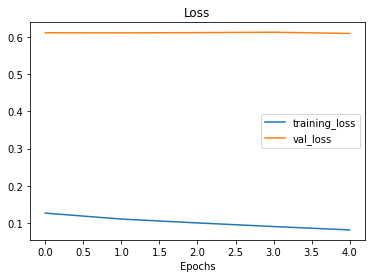

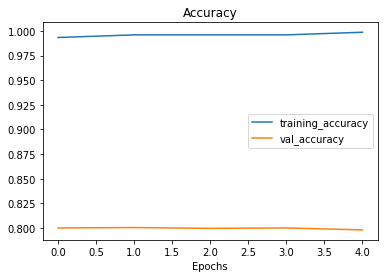

In [ ]:
plot_loss_curves(rasnet_history)

### Creating and testing EfficientNetB0 TensorFlow Hub Feature Extraction model

In [ ]:
# Create EfficinetNetB0 feature extractor model
efficientnet_model = create_model(efficient_net_url, train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss = 'categorical_crossentropy',
                           optimizer = Adam(),
                           metrics = ['accuracy'])

# Fit EfficientNet model to 10% of training data
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                       epochs = 5,
                       steps_per_epoch = len(train_data_10_percent),
                       validation_data = test_data,
                       validation_steps = len(test_data),
                       callbacks = [create_tensorboard_callbacks(dir_names = 'Tesnorflow_hub',
                                                                            experiment_name = 'EfficientNetB0')])

Saving TensorBoard log files to: Tesnorflow_hub/EfficientNetB02023-02-24_04:47:43
Epoch 1/5
24/24 [==============================] - 27s 765ms/step - loss: 1.8410 - accuracy: 0.4400 - val_loss: 1.2941 - val_accuracy: 0.7460
Epoch 2/5
24/24 [==============================] - 16s 670ms/step - loss: 1.0449 - accuracy: 0.7747 - val_loss: 0.8628 - val_accuracy: 0.8244
Epoch 3/5
24/24 [==============================] - 15s 661ms/step - loss: 0.7447 - accuracy: 0.8400 - val_loss: 0.6958 - val_accuracy: 0.8456
Epoch 4/5
24/24 [==============================] - 25s 1s/step - loss: 0.6011 - accuracy: 0.8667 - val_loss: 0.6055 - val_accuracy: 0.8584
Epoch 5/5
24/24 [==============================] - 25s 1s/step - loss: 0.5102 - accuracy: 0.8933 - val_loss: 0.5567 - val_accuracy: 0.8624


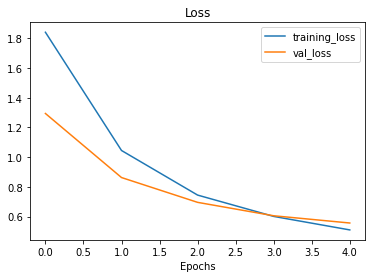

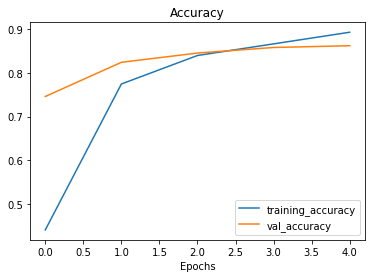

In [ ]:
plot_loss_curves(efficientnet_history)

## Different types of transfer learning

* **"As is" transfer learning** - using an existing model with no changes what so ever (e.g using ImageNet model on 1000 ImageNet classes, none of your own)
* **"Feature extraction"** transfer learning - use the prelearned patterns of an existing model (e.g. EfficientNetB0 trained on ImageNet) and adjust the output layer for your own problem (e.g. 1000 classes -> 10 classes of food)
* **"Fine-tuning" transfer learning** - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers)
